# Performing data and compatibility analysis

**pyddt** main goal is to establish a set of systematic procedures for indexing dynamical diffraction peaks and reading their line profile asymmetries, so this approach of using X-ray dynamical diffraction becomes reproducible and transferable.

This last tutorial aims to show the standard procedures implemented into **pyddt** and analyze two data sets using them.

### 0. Importing packages

In this tutorial, it's necessary to use the magic function `%matplotlib qt`. Using it, matplotlib plots will be opened on an external window from the notebook.  

In [10]:
%matplotlib qt  

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '10'

import sys
sys.path.append('/home/rafaela/doutorado/pyddt')

import pyddt

## 1. Analyzing Renninger scans

### 1.1 CeFe$_4$P$_{12}$

Let's start by analyzing the scan of the reflection 002, filled skutterudite CeFe$_{4}$P$_{12}$.

X-ray data acquisition was carried out at the Brazilian Synchrotron Light Laboratory (LNLS), bending magnetic
beamline XRD2. X-rays of 7105.8 eV.

See [Phonon scattering mechanism in thermoelectric materials revised via resonant x-ray dynamical diffraction](https://link.springer.com/article/10.1557/mrc.2020.37) for a detailed reference.

#### 1.1.1 ExpData object

Creating an `expdata` object is the first step of data analysis. The necessary inputs are energy value, primary reflection indices, and the filename containing the data.

The data must include the azimuth position and corresponding intensity. For the filled skutterudite, the filename is `data_CFP.dat`.

In [29]:
exp = pyddt.ExpData(7105.8, [0, 0, 2], 'data_CFP.dat')

Once this object was generated, we can visualize the scan. 

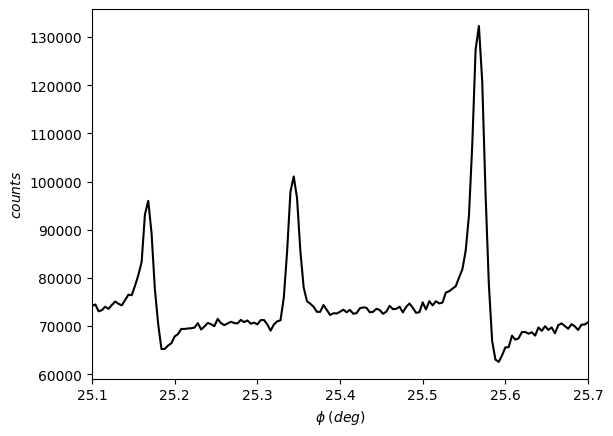

In [13]:
exp.plot()

#### 1.1.2 Selecting the MD peaks

Now, we proceed to find the multiple-diffraction (MD) peaks. You can inform the minimum height to be considered (provide a percentage of the maximum intensity). 

For this dataset, 60% is a good choice. Feel free to test other values.

In [30]:
exp.peak_finder(0.6) 

Visualize the scan again to check the selected peaks. You can access the peak positions by using the `phi` and `peaks` attributes.

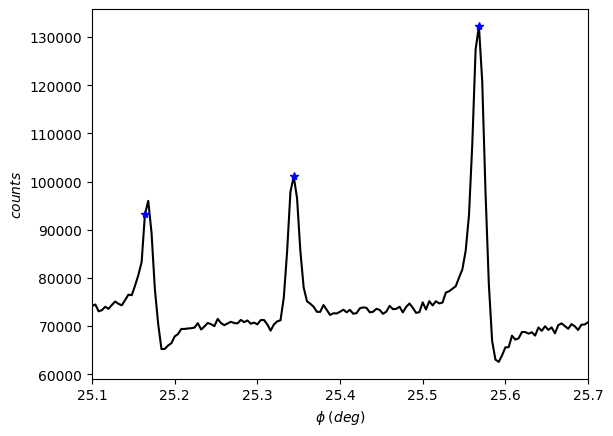

In [15]:
exp.plot()

In [16]:
exp.phi[exp.peaks]

array([25.164, 25.344, 25.568])

Our scan is very narrow, so it's perfectly possible to select the peaks manually. Use the function `pyddt.peak_picker()` for it. 

Also, you can delete peaks by using the function `pyddt.review()`: 

* To select a peak, stop the mouse over the maximum and press SPACE.

* To unselect, stop the mouse over the maximum and press DEL.

* Feel free to zoom in or out.

* After finishing the selection, press ENTER. Then, close the figure (mouse or press q).


#### 1.1.3 Defining the fitting regions

For reading the asymmetries, we fit a superposition of a symmetric peak with a linear slope. This way, it's necessary to define the fitting region for each selected peak. 

The function `pyddt.region_of_fit()` manually calculates the *full width at half maximum* $f$ for each peak, then defines the region of fit as 

$$\phi_{0} \pm nf$$

where $\phi_{0}$ is the center position and $n\in \mathcal{Z}$. By default, $n = 15$.

The calculated regions are exhibited by using `flag = 1`.

In [32]:
exp.region_of_fit(flag=1)

![pyddt_t3_1](https://user-images.githubusercontent.com/106104347/187980762-c1e598c3-6f47-400f-b570-1c151c76f63b.png)

#### 1.1.4 Indexing the multiple-diffraction cases

Now, let's index the MD peaks. To do this, use the `pyddt.indexer()` function. The secondary reflections are exhibited by using `flag = 1`.

In [33]:
exp.indexer('ce3.in', [1, 1, 0], 50, flag=1)

![pyddt_t3_2](https://user-images.githubusercontent.com/106104347/187985771-3f126b90-6c8a-46ff-8315-3396608281c8.png)

`exp.indexer()` arguments:

* Structural model (generated in the last tutorial). 
* Reference direction for the azimuthal rotation
* Minimum cutoff for the strength of excitation. 

The red color of the 4-beam peaks indicates the *in-out* geometry of excitation, while blue stands for out-in. 

It's also possible directly index the MD peaks by visualizing $\omega \times \phi$ graphs. The secondary reflections are shown as hover text by mouse motions.

In [ ]:
exp.BC_plot('ce3.in', [1, 1, 0], 50)

You can also access the indexation by calling the `index` attribute, where $\pm 1$ stands for the excitation geometry.

In [24]:
exp.index

array([['1', '4 1 3/ 4 1 -1'],
       ['-1', '-3 4 1'],
       ['1', '4 2 4/ 4 2 -2']], dtype='<U21')

#### 1.1.5 Asymmetry reading

Finally, let's fit the MD peaks and read their asymmetry.

In [34]:
exp.fitter(100)

100%|█████████████████████████████████████████████| 3/3 [00:12<00:00,  4.11s/it]


The slope error is estimated using [bootstrap resampling](https://onlinelibrary.wiley.com/doi/full/10.1002/9780470057339.vab028), and the number of resamples is the only argument of `exp.fitter()` function.

Let's check the estimated slopes and their errors.

In [26]:
exp.slope_data

array([[-0.19067251,  0.05101513],
       [ 0.10344877,  0.00676736],
       [-0.20538606,  0.10659999]])

It's easy to relate the slope sign with the asymmetry type: if negative, the asymmetry is HL (the MD intensity profile has higher/lower shoulders); if positive, it's LH.

So, the MD peaks observed at $\phi = $25.16º and 25.57º are HL, while the remaining is LH. 

In [37]:
exp.asymmetry_assigner(0, 10, flag=1)  # flag = 1 to exhibits the asymmetries

![pyddt_t3_4](https://user-images.githubusercontent.com/106104347/187992200-5db7adc9-9d0e-4627-8fbe-5e9cd15705ed.png)

The `exp.asymmetry_assigner` function realizes the asymmetry reading based on the slope sign. Take a look at the [API documentation](api.rst) for exploiting the first arguments (cutoff values of $\bar{S}$ and $\tau$). 

#### 1.1.6 Saving the analysis

We have indexed the multiple-diffraction cases and read their asymmetries, so the analysis is finished. Let's save the results.

In [38]:
exp.save()

'_E7105.8_G002'

In the current folder, two new files are available: `_E7105.8_G002.ext` and `_E7105.8_G002.red`. Take a look at them.

* *.ext* $\rightarrow$ peak position, hkl, slope, slope error, statistical properties, asymmetry type, and excitation geometry.

* *.red* $\rightarrow$  hkl, asymmetry, and diffraction geometry (primary indices and energy in 1st line).

### 1.2 Fe-doped L-asparagine monohydrated

It may seem too much effort to analyze this data using **pyddt**, since a visual analysis quickly leads to the same conclusions. However, a visual inspection is unworkable as the data set increases. In this situation, **pyddt** is very helpful.

Another advantage of using **pyddt** is the analysis of biological materials or X-ray data acquisition on laboratory setups, in which asymmetric profiles aren't so well-marked.

For illustrating these situations, let's quickly analyze the scan of the reflection 026, Fe-doped L-asparagine monohydrated.

X-ray data acquisition was carried out at the Sirius, beamline EMA. X-rays of 8048 eV.

#### 1.2.1 Loading data

In [39]:
exp2 = pyddt.ExpData(8048, [0, 2, 6], 'data_lasp.dat')

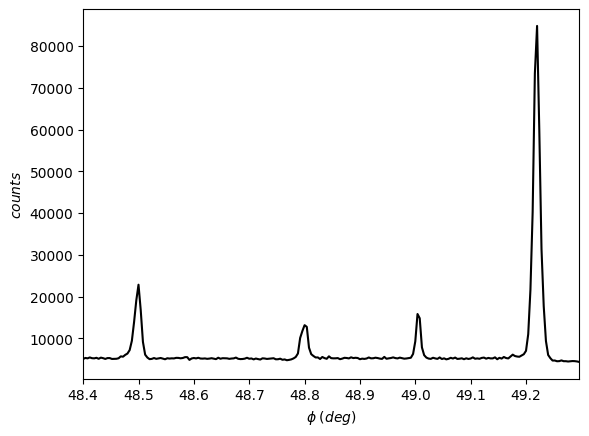

In [40]:
exp2.plot()

Please, note how the asymmetries are subtle, and a visual asymmetry reading is tricky.

#### 1.2.2 Selecting the MD peaks

In [44]:
exp2.peak_finder(0.1)

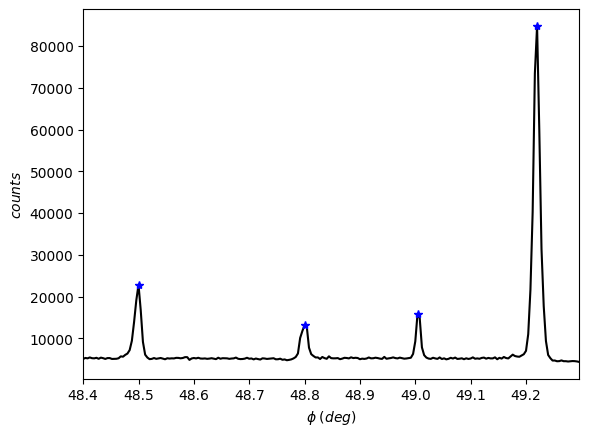

In [45]:
exp2.plot()

#### 1.2.3 Defining the fitting regions

In [50]:
exp2.region_of_fit(5, flag=1)

![pyddt_t3_5](https://user-images.githubusercontent.com/106104347/187998792-4fcb6b13-ebae-47e0-b539-fcec5b5d186d.png)

#### 1.2.4 Asymmetry reading

In [51]:
exp2.fitter(100)

100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.28s/it]


In [52]:
exp2.slope_data

array([[-0.17184866,  0.10397331],
       [ 0.15763806,  0.05487308],
       [-0.12616801,  0.08049835],
       [-0.95195789,  0.11601925]])

Compare these values with the estimated for the skutterudite. The ratio slope error/slope is higher now, which indicates low-resolution asymmetries. In this context, **pyddt** is very helpful.

## 2. Compatibility analysis

Returning to the filled skutterudite data, we will show how to compare the experimental asymmetries with the predicted structural models.

Within **pyddt**, the compatibility analysis is performed by the `AMD` class. The required inputs are the *.red* file saved after the data analysis and the structural models (created in the last tutorial).

In [53]:
amd = pyddt.AMD('_E7105.8_G002.red', ['ce3.in', 'ce4.in'])

Let's check the experimental asymmetries.

In [54]:
amd.asy

array(['HL', 'LH', 'HL'], dtype='<U2')

Now, we will use the `amd.theoretical_asymmetries()` function to calculate the asymmetries predicted by each structural model.

In [55]:
amd.theoretical_asymmetries()

In [56]:
amd.theo_asy

array([[1., 0., 1.],
       [1., 0., 1.]], dtype=float128)

The first line of `amd.theo_asy` presents the asymmetries calculated by the model `ce3.in`, where 1 stands for HL and 0 for LH. The asymmetries in the second line were calculated by the model `ce4.in`.

The multiple-diffraction cases under evaluation don't allow differentiation of the structural models.

In [57]:
amd.hkl

array([[ 4.,  1.,  3.],
       [-3.,  4.,  1.],
       [ 4.,  2.,  4.]])

**pyddt** has other advanced tools for compatibility analysis, which will not be covered in this tutorial. Please, check the [API documentation](api.rst) for more details.